# Taxonomy Classification Data Analysis
This notebook analyzes the taxonomy dataset to guide classifier development decisions.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import sys
# Add the src directory to path for imports
sys.path.append('../src/reformat_data')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Load and Explore the Dataset

In [24]:
# Load the processed taxonomy data
data_path = '../data/merged/new_classes.csv'
df = pd.read_csv(data_path, dtype=str)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2141267, 16)


,seqID,taxID,scientific_name,sequence,superkingdom_name,kingdom_name,phylum_name,class_name,order_name,family_name,genus_name,species_name,euk_class,metazoa_class,arthropoda_class,insecta_class
0,ManCurSeq_DUFA-COLR-000000001555472-H00000001,1010000010,Bordaia karnka,TTTATCATCAAATATTGCTCATGCTGGTAGATCAGTAGATCTAGCT...,Eukaryota,Metazoa,Arthropoda,Insecta,Lepidoptera,Hepialidae,Bordaia,Bordaia karnka,Metazoa,Arthropoda,Insecta,Lepidoptera
1,ManCurSeq_DUFA-COLR-000000001555472-H00000002,1010000010,Bordaia karnka,TTTATCATCAAATATTGCTCATGCTGGTAGATCAGTAGATTTAGCT...,Eukaryota,Metazoa,Arthropoda,Insecta,Lepidoptera,Hepialidae,Bordaia,Bordaia karnka,Metazoa,Arthropoda,Insecta,Lepidoptera
2,ManCurSeq_DUFA-COLR-000000001555333-H00000001,1010000011,Amata pr.,ACTTTCATCTAATATTGCTCATAGAGGAAGTTCAGTTGATTTAGCT...,Eukaryota,Metazoa,Arthropoda,Insecta,Lepidoptera,Erebidae,Amata,Amata pr.,Metazoa,Arthropoda,Insecta,Lepidoptera
3,ManCurSeq_DUFA-COLR-000000001560174-H00000001,1010000012,Lophoptera pr.,ACTTTCATCTAATATTGCACATGGAGGAAGATCAGTTGATTTAGCA...,Eukaryota,Metazoa,Arthropoda,Insecta,Lepidoptera,Euteliidae,Lophoptera,Lophoptera pr.,Metazoa,Arthropoda,Insecta,Lepidoptera
4,ManCurSeq_DUFA-COLR-000001000000019-H00000001,1010000013,Abyssoninoe scopa,GCTAGCTAGAAACATGGCCCATGCAGGCCCATCTGTAGATTTAGCA...,Eukaryota,Metazoa,Annelida,Polychaeta,Eunicida,Lumbrineridae,Abyssoninoe,Abyssoninoe scopa,Metazoa,Annelida,No_arthropoda,No_insecta


In [25]:
# Basic statistics
print(f"Total number of sequences: {len(df)}")
print(f"Unique taxonomic IDs: {df['taxID'].nunique()}")

Total number of sequences: 2141267
Unique taxonomic IDs: 224040


## 2. Analyze Taxonomic Rank Coverage

In [26]:
# Define taxonomy ranks
taxonomy_ranks = ['euk_class', 'metazoa_class', 'arthropoda_class', 'insecta_class']
# Check missing values across taxonomic rank
missing_data = df[taxonomy_ranks].isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_stats = pd.DataFrame({'Missing Values': missing_data,'Percentage': missing_percent})
missing_stats

,Missing Values,Percentage
euk_class,0,0.0
metazoa_class,0,0.0
arthropoda_class,0,0.0
insecta_class,0,0.0


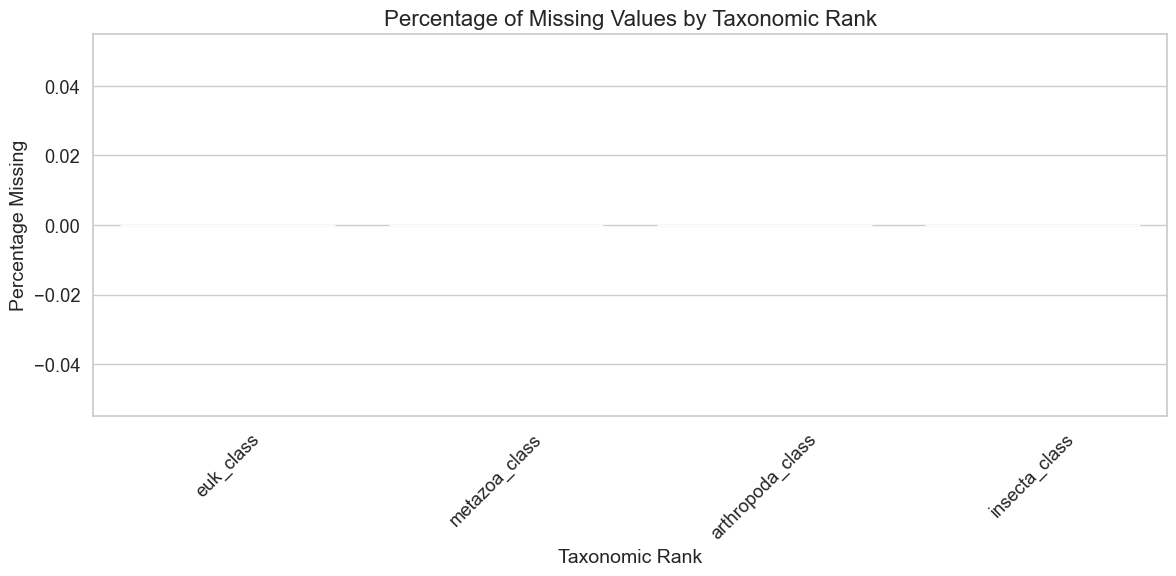

In [27]:
# Visualize missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_stats.index, y='Percentage', data=missing_stats)
plt.title('Percentage of Missing Values by Taxonomic Rank', fontsize=16)
plt.title('Percentage of Missing Values by Taxonomic Rank', fontsize=16)
plt.ylabel('Percentage Missing', fontsize=14)
plt.xlabel('Taxonomic Rank', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Check approximated values
approximated = {}
for rank in [r.replace('_class', '') for r in taxonomy_ranks]:
    col = f"{rank}_class"
    approximated[rank] = df[df[col].str.contains('from', na=False)].shape[0]
    approx_df = pd.DataFrame.from_dict(approximated, orient='index', columns=['Count'])
    approx_df['Percentage'] = (approx_df['Count'] / len(df)) * 100
    approx_df.sort_values('Percentage', ascending=False)

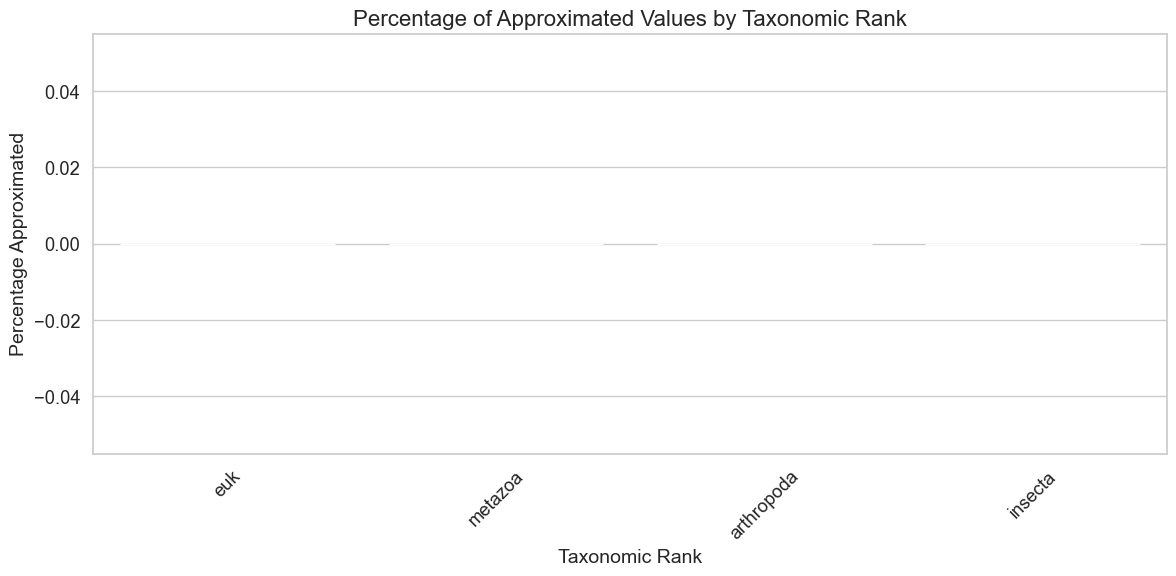

In [29]:
# Visualize approximated values
plt.figure(figsize=(12, 6))
sns.barplot(x=approx_df.index, y='Percentage', data=approx_df)
plt.title('Percentage of Approximated Values by Taxonomic Rank', fontsize=16)
plt.ylabel('Percentage Approximated', fontsize=14)
plt.xlabel('Taxonomic Rank', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Analyze Taxonomic Distribution

In [30]:
# Create function to display taxonomic ranks as a table
def display_rank_distribution_table(df, rank_col):
    # Get value counts for the rank
    counts = df[rank_col].value_counts().reset_index()
    counts.columns = [rank_col.replace('_class', '').capitalize(), 'Number of Sequences']
    
    # Calculate percentage
    counts['Percentage (%)'] = (counts['Number of Sequences'] / len(df) * 100).round(2)
    
    # Sort by count in descending order
    counts = counts.sort_values('Number of Sequences', ascending=False)
    
    # Style the table for better visualization
    styled_table = counts.style.background_gradient(subset=['Number of Sequences'], cmap='Blues')\
                          .background_gradient(subset=['Percentage (%)'], cmap='Greens')\
                          .format({'Percentage (%)': '{:.2f}%'})\
                          .set_caption(f"Distribution of {rank_col.replace('_name', '').capitalize()}")
    
    return styled_table

# Display tables for each taxonomic rank
for rank in taxonomy_ranks:
    print(f"\n## Distribution of {rank.replace('_name', '').capitalize()}")
    display(display_rank_distribution_table(df, rank))


## Distribution of Euk_class


,Euk,Number of Sequences,Percentage (%)
0,Metazoa,2114363,98.74%
1,Others,24175,1.13%
2,Viridiplantae,1885,0.09%
3,Fungi,787,0.04%
4,No_euk,57,0.00%



## Distribution of Metazoa_class


,Metazoa,Number of Sequences,Percentage (%)
0,Arthropoda,1680612,78.49%
1,Chordata,246513,11.51%
2,Mollusca,97636,4.56%
3,Annelida,33095,1.55%
4,No_metazoa,26904,1.26%
5,Others,21756,1.02%
6,Echinodermata,17070,0.80%
7,Platyhelminthes,9194,0.43%
8,Cnidaria,8487,0.40%



## Distribution of Arthropoda_class


,Arthropoda,Number of Sequences,Percentage (%)
0,Insecta,1450703,67.75%
1,No_arthropoda,460655,21.51%
2,Arachnida,107761,5.03%
3,Malacostraca,69632,3.25%
4,Collembola,19865,0.93%
5,Hexanauplia,9780,0.46%
6,Thecostraca,8822,0.41%
7,Branchiopoda,6553,0.31%
8,Chilopoda,2111,0.10%
9,Ostracoda,1904,0.09%



## Distribution of Insecta_class


,Insecta,Number of Sequences,Percentage (%)
0,No_insecta,690564,32.25%
1,Diptera,485955,22.69%
2,Lepidoptera,356784,16.66%
3,Hymenoptera,231947,10.83%
4,Coleoptera,191977,8.97%
5,Hemiptera,73192,3.42%
6,Others,34315,1.60%
7,Trichoptera,24034,1.12%
8,Orthoptera,20050,0.94%
9,Blattodea,8627,0.40%


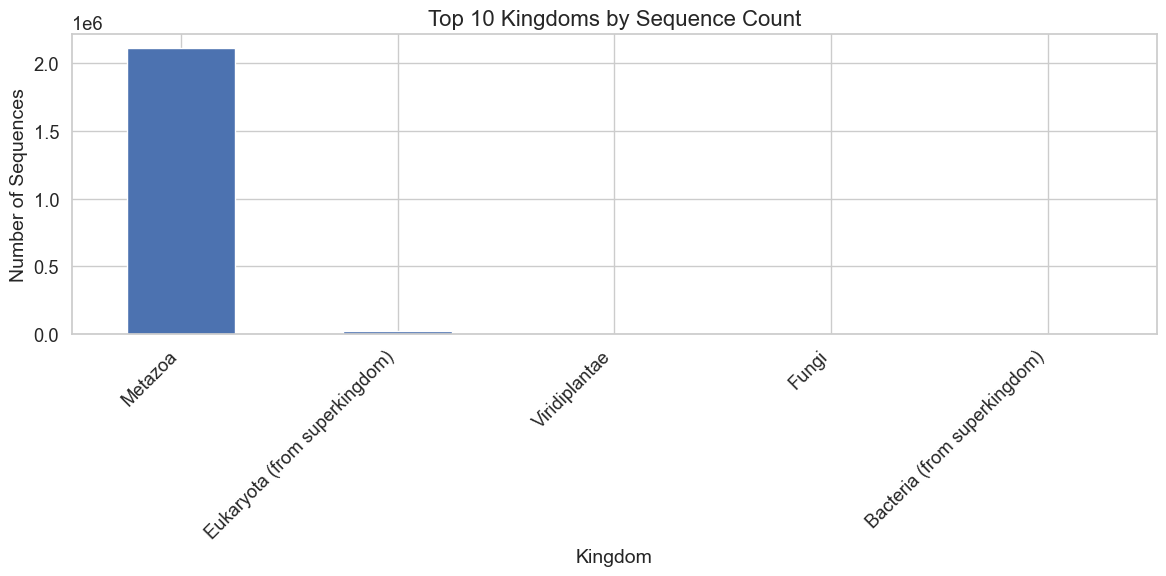

In [31]:
# Distribution of sequences by kingdom
plt.figure(figsize=(12, 6))
kingdom_counts = df['kingdom_name'].value_counts().head(10)
kingdom_counts.plot(kind='bar')
plt.title('Top 10 Kingdoms by Sequence Count', fontsize=16)
plt.ylabel('Number of Sequences', fontsize=14)
plt.xlabel('Kingdom', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

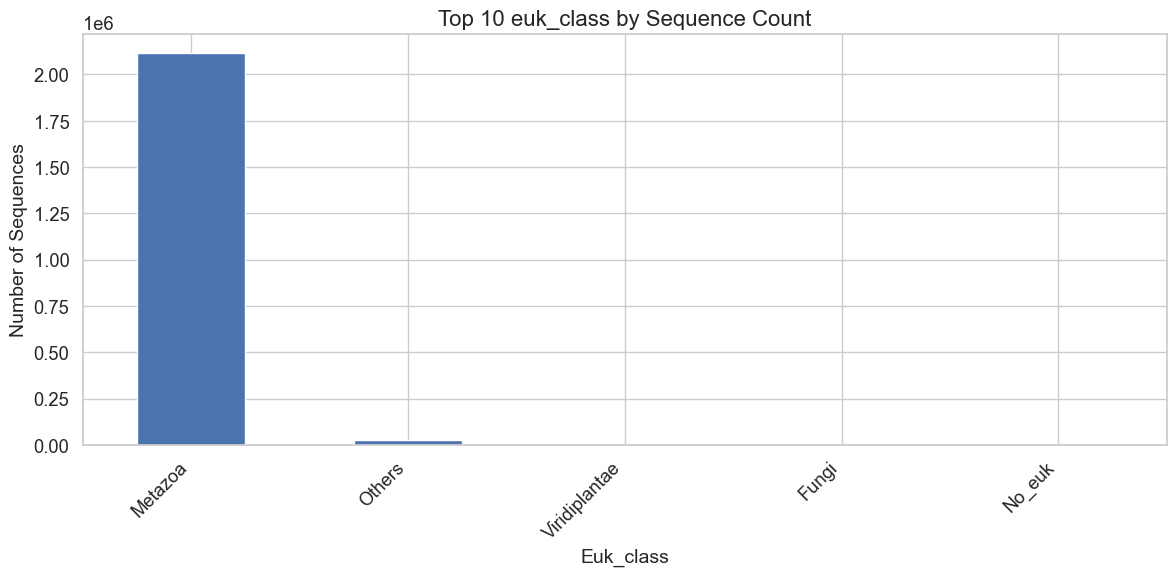

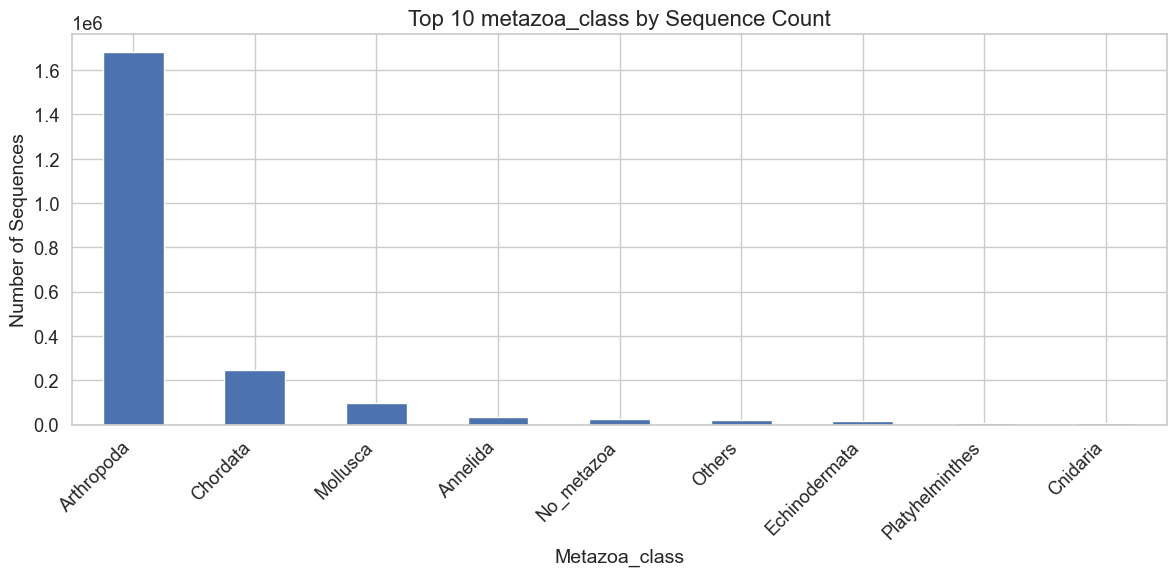

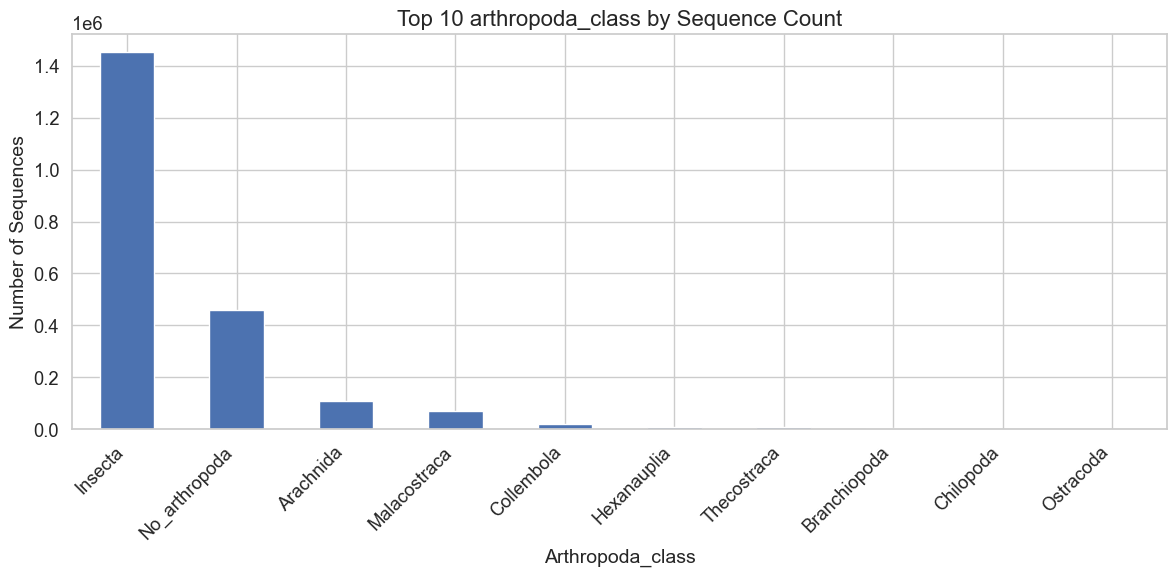

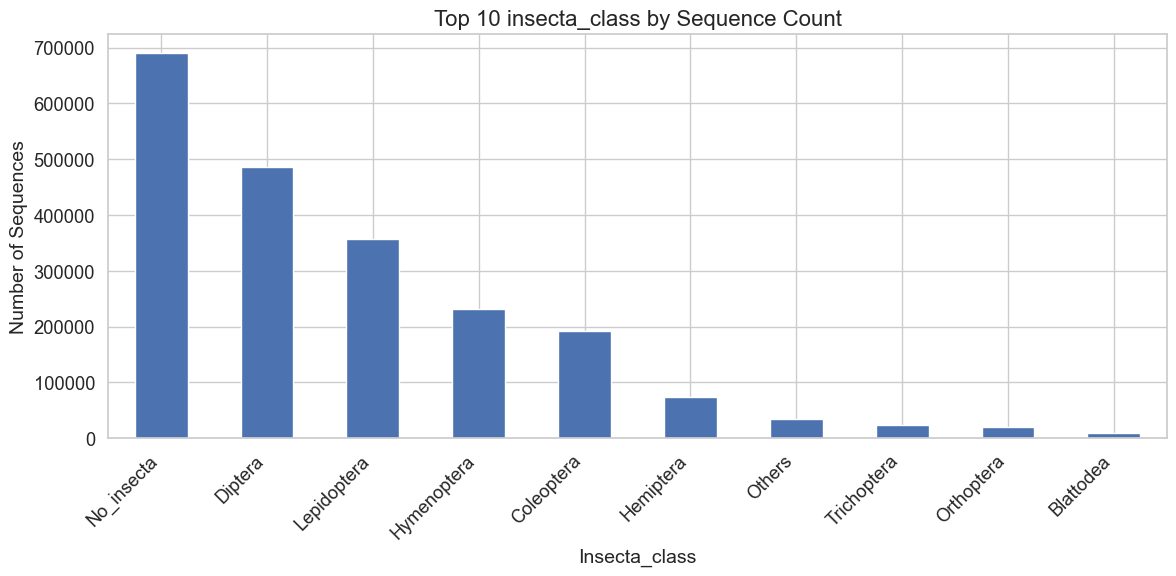

In [32]:
#Create a distribution analysis for each taxonomic rank",
def plot_rank_distribution(df, rank_col, top_n=10):
    counts = df[rank_col].value_counts().head(top_n)
    plt.figure(figsize=(12, 6))
    counts.plot(kind='bar')
    plt.title(f'Top {top_n} {rank_col.replace("_name", "")} by Sequence Count', fontsize=16)
    plt.ylabel('Number of Sequences', fontsize=14)
    plt.xlabel(rank_col.replace("_name", "").capitalize(), fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for rank in taxonomy_ranks:
    plot_rank_distribution(df, rank)

## 4. Sequence Length Analysis

In [33]:
# Calculate sequence lengths
df['seq_length'] = df['sequence'].str.len()
# Summary statistics for sequence length
print("Sequence Length Statistics:")
print(df['seq_length'].describe())      

Sequence Length Statistics:
count    2.141267e+06
mean     3.110944e+02
std      4.304744e+00
min      2.900000e+02
25%      3.120000e+02
50%      3.130000e+02
75%      3.130000e+02
max      3.200000e+02
Name: seq_length, dtype: float64


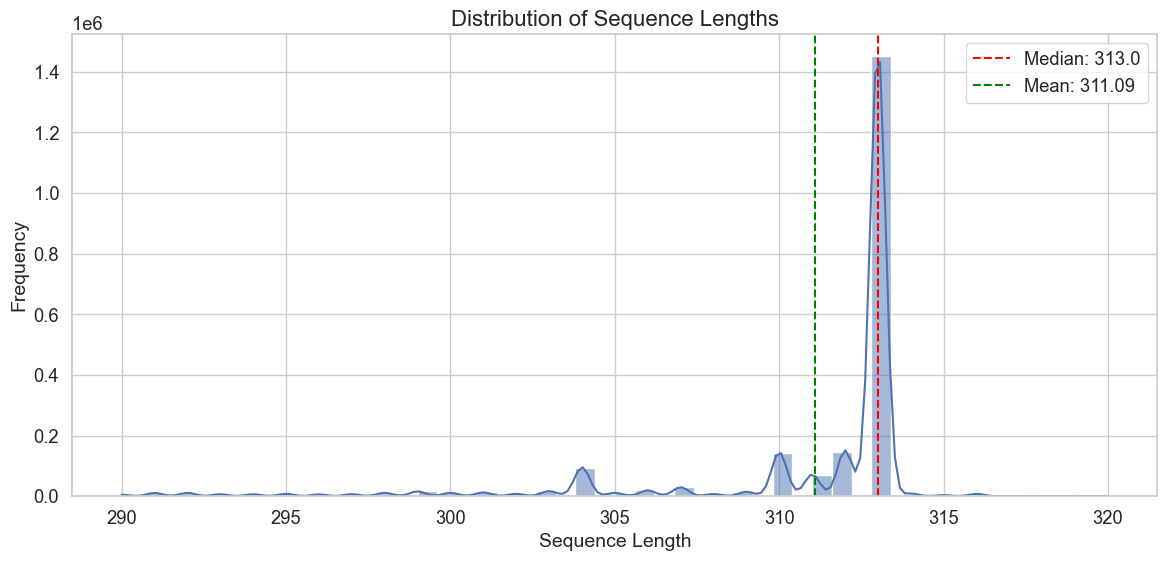

In [34]:
# Visualize sequence length distribution
plt.figure(figsize=(14, 6))
sns.histplot(df['seq_length'], bins=50, kde=True)
plt.title('Distribution of Sequence Lengths', fontsize=16)
plt.xlabel('Sequence Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(df['seq_length'].median(), color='red', linestyle='--', label=f'Median: {df["seq_length"].median()}')
plt.axvline(df['seq_length'].mean(), color='green', linestyle='--', label=f'Mean: {df["seq_length"].mean():.2f}')
plt.legend()
plt.show()

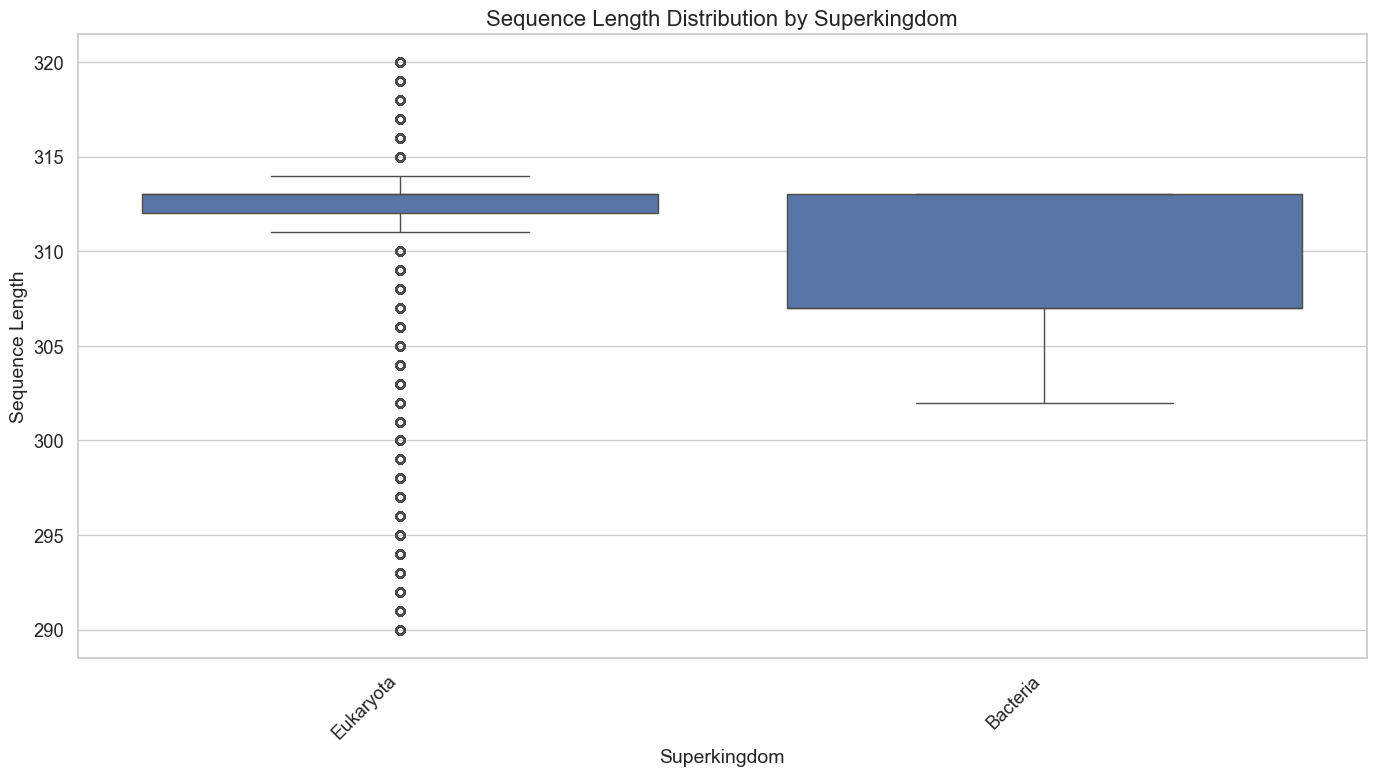

In [35]:
# Analyze sequence length by superkingdom
plt.figure(figsize=(14, 8))
sns.boxplot(x='superkingdom_name', y='seq_length', data=df)
plt.title('Sequence Length Distribution by Superkingdom', fontsize=16)
plt.xlabel('Superkingdom', fontsize=14)
plt.ylabel('Sequence Length', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Nucleotide Composition Analysis

In [36]:
# Calculate nucleotide frequencies
df['A_count'] = df['sequence'].str.count('A')
df['T_count'] = df['sequence'].str.count('T')
df['C_count'] = df['sequence'].str.count('C')
df['G_count'] = df['sequence'].str.count('G')
df['N_count'] = df['sequence'].str.count('N')
# Calculate percentages
for base in ['A', 'T', 'C', 'G', 'N']:
    df[f'{base}_percent'] = df[f'{base}_count'] / df['seq_length'] * 100
# Calculate GC content
df['GC_content'] = (df['G_count'] + df['C_count']) / df['seq_length'] * 100
# Display nucleotide composition statistics
nucleotide_stats = df[['A_percent', 'T_percent', 'G_percent', 'C_percent', 'N_percent', 'GC_content']].describe()
nucleotide_stats

,A_percent,T_percent,G_percent,C_percent,N_percent,GC_content
count,2.141267e+06,2.141267e+06,2.141267e+06,2.141267e+06,2141267.0,2.141267e+06
mean,2.762740e+01,3.877088e+01,1.449716e+01,1.910456e+01,0.0,3.360172e+01
std,3.359496e+00,5.081240e+00,2.773327e+00,5.407417e+00,0.0,6.536897e+00
min,1.225806e+01,1.884984e+01,2.960526e+00,6.070288e+00,0.0,1.184211e+01
25%,2.555911e+01,3.621795e+01,1.309904e+01,1.565495e+01,0.0,2.907348e+01
50%,2.779553e+01,3.993610e+01,1.437700e+01,1.757188e+01,0.0,3.226837e+01
75%,2.971246e+01,4.217252e+01,1.597444e+01,2.108626e+01,0.0,3.709677e+01
max,4.508475e+01,6.026059e+01,4.185304e+01,4.345048e+01,0.0,6.581470e+01


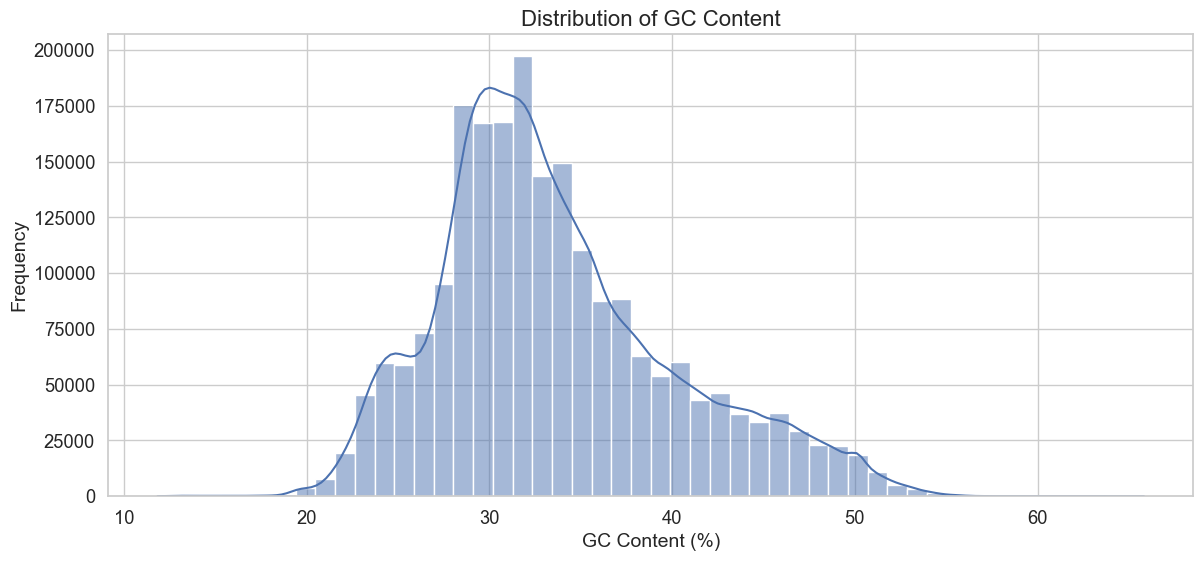

In [37]:
# Visualize GC content distribution
plt.figure(figsize=(14, 6))
sns.histplot(df['GC_content'], bins=50, kde=True)
plt.title('Distribution of GC Content', fontsize=16)
plt.xlabel('GC Content (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

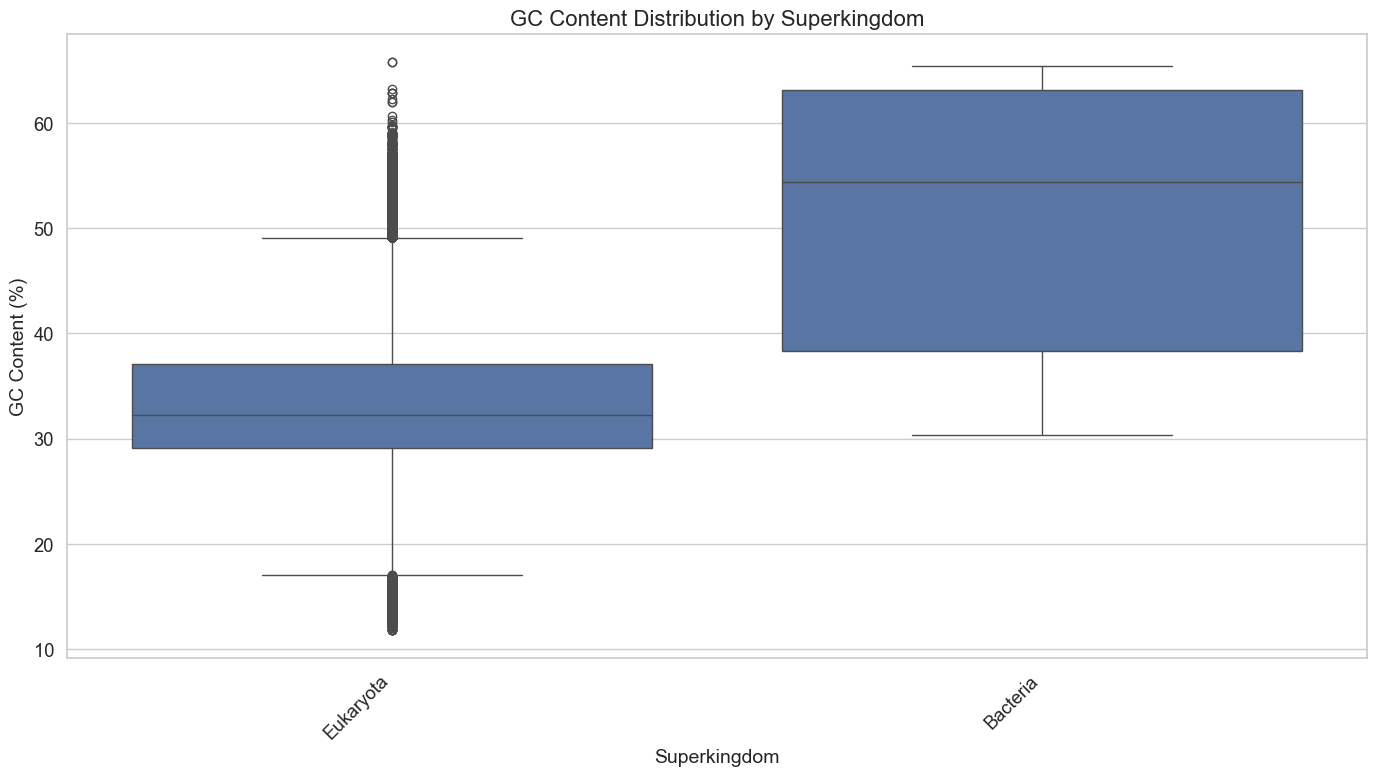

In [16]:
# Compare GC content by superkingdom
plt.figure(figsize=(14, 8))
sns.boxplot(x='superkingdom_name', y='GC_content', data=df)
plt.title('GC Content Distribution by Superkingdom', fontsize=16)
plt.xlabel('Superkingdom', fontsize=14)
plt.ylabel('GC Content (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Taxonomic Classification Considerations

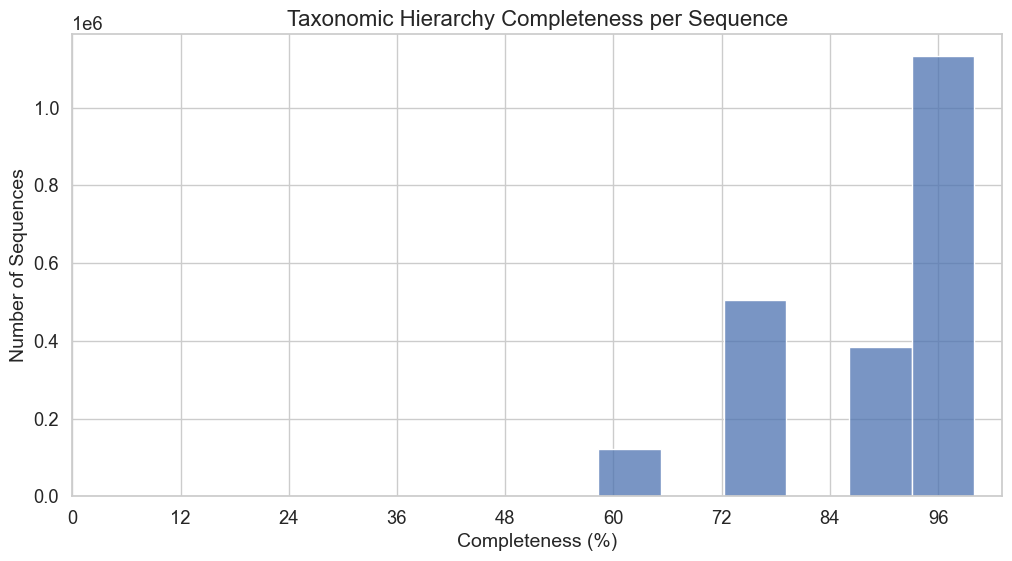

In [17]:
# Evaluate hierarchy completeness for each sequence
df['completeness'] = df[taxonomy_ranks].notna().sum(axis=1) / len(taxonomy_ranks) * 100
plt.figure(figsize=(12, 6))
sns.histplot(df['completeness'], bins=len(taxonomy_ranks) + 1, kde=False)
plt.title('Taxonomic Hierarchy Completeness per Sequence', fontsize=16)
plt.xlabel('Completeness (%)', fontsize=14)
plt.ylabel('Number of Sequences', fontsize=14)
plt.xticks(range(0, 101, int(100/len(taxonomy_ranks))))
plt.show()

In [18]:
# Find most imbalanced taxonomic ranks
rank_imbalance = {}
for rank in taxonomy_ranks:
    value_counts = df[rank].value_counts()
    if len(value_counts) >= 10:
        imbalance_ratio = value_counts.iloc[0] / value_counts.iloc[9]
    else:
        imbalance_ratio = value_counts.iloc[0] / value_counts.iloc[-1] if len(value_counts) > 1 else float('inf')
    
    rank_imbalance[rank] = {
        'unique_values': len(value_counts),
        'top_value': value_counts.index[0],
        'top_count': value_counts.iloc[0],
        'imbalance_ratio': imbalance_ratio
    }

pd.DataFrame(rank_imbalance).T

,unique_values,top_value,top_count,imbalance_ratio
superkingdom_name,2,Eukaryota,2141210,37565.087719
kingdom_name,5,Metazoa,2114363,37094.087719
phylum_name,56,Arthropoda,1680612,469.969799
class_name,186,Insecta,1450703,84.668087
order_name,888,Diptera,485955,24.211798
family_name,5630,Cecidomyiidae,90597,2.831776
genus_name,52453,Megaselia,22863,5.827938
species_name,192291,Bactrocera dorsalis,4360,5.0


## 7. Feature Engineering Approaches

In [19]:
# Calculate k-mer frequencies (example with 3-mers)
from collections import Counter
import itertools
import random
# Sample some sequences for demonstration
sample_size = min(1000, len(df))
sample_indices = random.sample(range(len(df)), sample_size)
sample_df = df.iloc[sample_indices].copy()
# Generate all possible 3-mers
bases = ['A', 'T', 'G', 'C']
kmers_3 = [''.join(p) for p in itertools.product(bases, repeat=3)]
# Function to count k-mers in a sequence
def count_kmers(seq, k=3):
    return Counter(seq[i:i+k] for i in range(len(seq) - k + 1))

# Apply to sample
sample_df['kmer_counts'] = sample_df['sequence'].apply(count_kmers)
# Extract k-mer features
kmer_features = pd.DataFrame(index=sample_df.index)
for kmer in kmers_3:
    kmer_features[f'kmer_{kmer}'] = sample_df['kmer_counts'].apply(lambda x: x.get(kmer, 0) / sum(x.values()))
# Preview k-mer features
kmer_features.head()


,kmer_AAA,kmer_AAT,kmer_AAG,kmer_AAC,kmer_ATA,kmer_ATT,kmer_ATG,kmer_ATC,kmer_AGA,kmer_AGT,kmer_AGG,kmer_AGC,kmer_ACA,kmer_ACT,kmer_ACG,kmer_ACC,kmer_TAA,kmer_TAT,kmer_TAG,kmer_TAC,kmer_TTA,kmer_TTT,kmer_TTG,kmer_TTC,kmer_TGA,kmer_TGT,kmer_TGG,kmer_TGC,kmer_TCA,kmer_TCT,kmer_TCG,kmer_TCC,kmer_GAA,kmer_GAT,kmer_GAG,kmer_GAC,kmer_GTA,kmer_GTT,kmer_GTG,kmer_GTC,kmer_GGA,kmer_GGT,kmer_GGG,kmer_GGC,kmer_GCA,kmer_GCT,kmer_GCG,kmer_GCC,kmer_CAA,kmer_CAT,kmer_CAG,kmer_CAC,kmer_CTA,kmer_CTT,kmer_CTG,kmer_CTC,kmer_CGA,kmer_CGT,kmer_CGG,kmer_CGC,kmer_CCA,kmer_CCT,kmer_CCG,kmer_CCC
477502,0.003215,0.035370,0.006431,0.009646,0.025723,0.048232,0.006431,0.016077,0.016077,0.006431,0.016077,0.016077,0.009646,0.032154,0.006431,0.009646,0.019293,0.041801,0.025723,0.028939,0.057878,0.102894,0.016077,0.003215,0.006431,0.016077,0.016077,0.009646,0.006431,0.009646,0.006431,0.009646,0.019293,0.012862,0.009646,0.006431,0.003215,0.019293,0.009646,0.006431,0.016077,0.016077,0.032154,0.012862,0.022508,0.009646,0.006431,0.000000,0.012862,0.006431,0.012862,0.012862,0.028939,0.012862,0.016077,0.006431,0.009646,0.000000,0.012862,0.000000,0.006431,0.012862,0.003215,0.003215
913515,0.032154,0.057878,0.000000,0.009646,0.032154,0.099678,0.000000,0.032154,0.006431,0.000000,0.016077,0.009646,0.019293,0.006431,0.000000,0.012862,0.025723,0.064309,0.012862,0.022508,0.077170,0.115756,0.016077,0.019293,0.012862,0.006431,0.003215,0.003215,0.028939,0.022508,0.003215,0.003215,0.006431,0.016077,0.012862,0.006431,0.003215,0.003215,0.000000,0.000000,0.019293,0.000000,0.006431,0.003215,0.009646,0.006431,0.000000,0.000000,0.035370,0.025723,0.006431,0.000000,0.012862,0.009646,0.009646,0.006431,0.003215,0.000000,0.003215,0.000000,0.009646,0.003215,0.003215,0.006431
560509,0.003226,0.016129,0.009677,0.003226,0.016129,0.054839,0.009677,0.016129,0.009677,0.003226,0.003226,0.012903,0.009677,0.016129,0.003226,0.000000,0.019355,0.045161,0.006452,0.025806,0.045161,0.077419,0.035484,0.029032,0.009677,0.032258,0.029032,0.019355,0.006452,0.029032,0.009677,0.012903,0.006452,0.025806,0.003226,0.000000,0.009677,0.025806,0.016129,0.009677,0.012903,0.019355,0.038710,0.012903,0.003226,0.032258,0.009677,0.003226,0.003226,0.009677,0.009677,0.000000,0.025806,0.029032,0.029032,0.003226,0.003226,0.006452,0.012903,0.003226,0.003226,0.009677,0.003226,0.000000
476696,0.000000,0.016077,0.003215,0.006431,0.016077,0.048232,0.012862,0.025723,0.006431,0.006431,0.003215,0.016077,0.006431,0.019293,0.003215,0.000000,0.019293,0.051447,0.012862,0.019293,0.048232,0.090032,0.028939,0.035370,0.019293,0.025723,0.022508,0.022508,0.003215,0.051447,0.006431,0.009646,0.003215,0.025723,0.006431,0.000000,0.009646,0.028939,0.016077,0.003215,0.009646,0.012862,0.025723,0.003215,0.012862,0.025723,0.006431,0.000000,0.003215,0.009646,0.009646,0.003215,0.028939,0.038585,0.032154,0.003215,0.000000,0.012862,0.000000,0.003215,0.003215,0.006431,0.000000,0.000000
797420,0.009646,0.028939,0.000000,0.016077,0.028939,0.051447,0.000000,0.028939,0.009646,0.009646,0.016077,0.016077,0.022508,0.022508,0.003215,0.016077,0.019293,0.038585,0.016077,0.035370,0.038585,0.070740,0.019293,0.038585,0.012862,0.009646,0.006431,0.009646,0.022508,0.041801,0.009646,0.003215,0.012862,0.022508,0.016077,0.006431,0.009646,0.009646,0.003215,0.000000,0.022508,0.003215,0.003215,0.000000,0.006431,0.019293,0.000000,0.000000,0.012862,0.019293,0.019293,0.006431,0.032154,0.038585,0.016077,0.006431,0.012862,0.000000,0.003215,0.000000,0.006431,0.009646,0.003215,0.006431


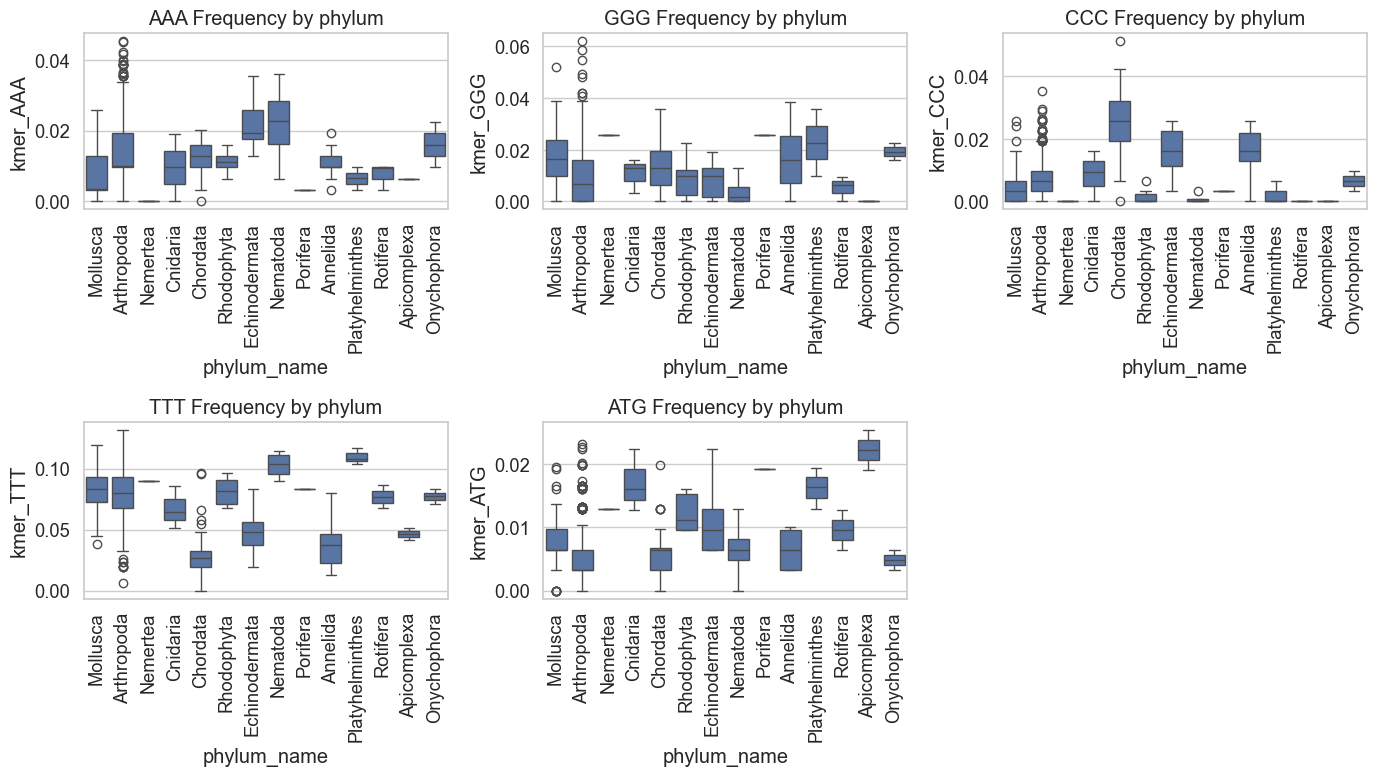

In [20]:
# Visualize distribution of select k-mer frequencies by family
plt.figure(figsize=(14, 8))
for i, kmer in enumerate(['AAA', 'GGG', 'CCC', 'TTT', 'ATG']):
    plt.subplot(2, 3, i+1)
    combined = pd.concat([sample_df['phylum_name'], kmer_features[f'kmer_{kmer}']], axis=1)
    sns.boxplot(x='phylum_name', y=f'kmer_{kmer}', data=combined)
    plt.title(f'{kmer} Frequency by phylum')
    plt.xticks(rotation=90)
    plt.tight_layout()
plt.tight_layout()
plt.show()

## 8. Classification Strategy

In [21]:
# Analyze data to determine optimal classification strategy
rank_stats = pd.DataFrame({
    'total_classes': [df[rank].nunique() for rank in taxonomy_ranks],
    'missing_percent': [(df[rank].isna().sum() / len(df)) * 100 for rank in taxonomy_ranks],
    'approx_percent': [(df[rank].str.contains('from', na=False).sum() / len(df)) * 100 for rank in taxonomy_ranks],
    'imbalance_ratio': [df[rank].value_counts().iloc[0] / df[rank].value_counts().iloc[-1] if len(df[rank].value_counts()) > 1 else float('inf') for rank in taxonomy_ranks]
})
rank_stats.index = [rank.replace('_name', '') for rank in taxonomy_ranks]
rank_stats['reliable_percent'] = 100 - rank_stats['missing_percent'] - rank_stats['approx_percent']
rank_stats['samples_per_class'] = len(df) / rank_stats['total_classes']
rank_stats

,total_classes,missing_percent,approx_percent,imbalance_ratio,reliable_percent,samples_per_class
superkingdom,2,0.000000,0.000000,3.756509e+04,100.000000,1.070634e+06
kingdom,5,0.000000,1.131666,3.709409e+04,98.868334,4.282534e+05
phylum,56,0.140945,0.000000,1.680612e+06,99.859055,3.823691e+04
class,186,0.172935,0.106993,1.450703e+06,99.720072,1.151219e+04
order,888,0.947196,0.174663,4.859550e+05,98.878141,2.411337e+03
family,5630,5.660294,0.053006,9.059700e+04,94.286700,3.803316e+02
genus,52453,29.015391,0.001775,2.286300e+04,70.982834,4.082258e+01
species,192291,46.089488,0.000934,4.360000e+03,53.909578,1.113555e+01


## 9. Visualization of Taxonomy

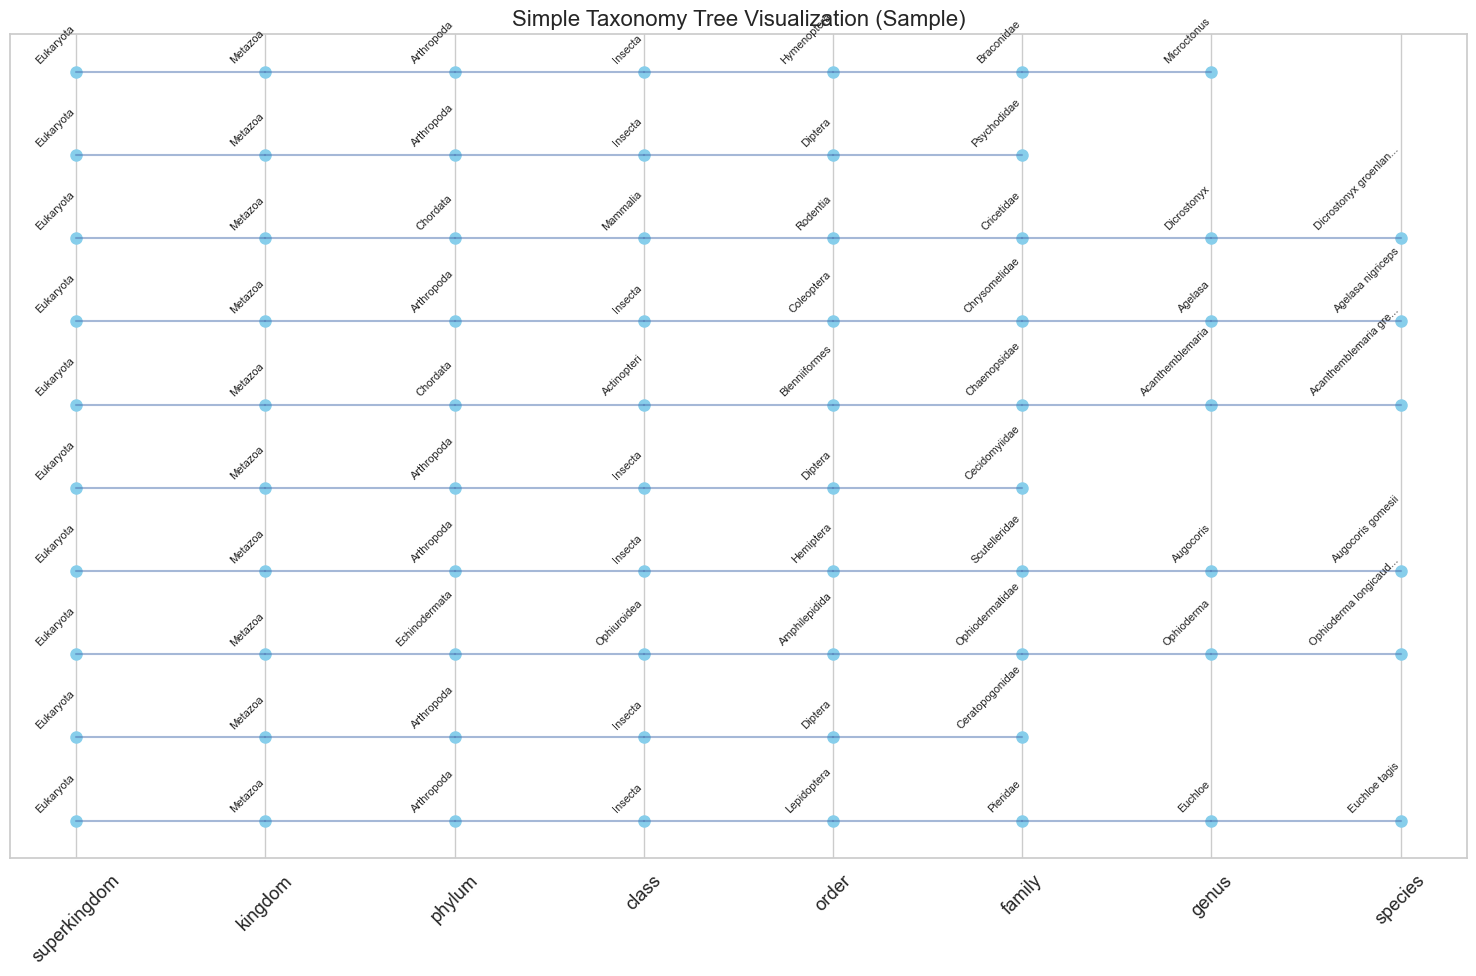

In [22]:
# Alternative taxonomy visualization without pygraphviz
def plot_simple_taxonomy_tree(df, max_samples=10):
    """Create a simple tree plot of taxonomic relationships for a few samples"""
    # Sample a few sequences
    sample_df = df.sample(max_samples)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    y_offset = 0
    
    for idx, row in sample_df.iterrows():
        x = 0
        y = y_offset
        
        # Plot each taxonomy level
        for i, rank in enumerate(taxonomy_ranks):
            if pd.notna(row[rank]):
                name = row[rank].split(' (from ')[0] if ' (from ' in row[rank] else row[rank]
                taxon_name = name[:20] + '...' if len(name) > 20 else name
                
                # Add node
                ax.plot(i, y, 'o', markersize=8, color='skyblue')
                ax.text(i, y+0.1, taxon_name, rotation=45, ha='right', fontsize=8)
                
                # Add edge if not first node
                if i > 0:
                    ax.plot([i-1, i], [y, y], 'b-', alpha=0.5)
            
        y_offset += 1
    
    # Set axis labels and ticks
    ax.set_xticks(range(len(taxonomy_ranks)))
    ax.set_xticklabels([r.replace('_name', '') for r in taxonomy_ranks], rotation=45)
    ax.set_yticks([])
    ax.set_title('Simple Taxonomy Tree Visualization (Sample)', fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Use the function
plot_simple_taxonomy_tree(df)